<a href="https://colab.research.google.com/github/marianobonelli/GeoLab_Consultagro/blob/main/CONSULTAGRO_v_1_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[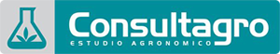](http://www.consultagroest.com.ar/)


**Desarrollado por** [**Mariano Bonelli**](https://www.linkedin.com/in/mariano-francisco-bonelli/)



---



In [ ]:
#@title 1. Instalación e importación de librerías { vertical-output: true }
%%capture
!rm -r /content/sample_data # elimina la carpeta export del directorio /sample_data/
!pip install geopandas
!pip install leafmap
!pip install ipysheet
!pip install folium matplotlib mapclassify
import ipysheet
import geopandas as gpd
import pandas as pd
import chardet
import glob
import ipywidgets as widgets
from ipywidgets import Dropdown
from google.colab import files
from shapely.geometry import Point
import fileinput
import zipfile
import shutil
import os
import fiona
from fiona.crs import from_epsg
import re
import folium



---



In [ ]:
#@title 2. Importación de archivos { vertical-output: true }

uploaded = files.upload()



---



In [ ]:
#@title 3. Lectura del archivo con resultados de laboratorio: { vertical-output: true }

# Buscar todos los archivos .xlsx en el directorio /content/
file_path = glob.glob('/content/*.xlsx')

# Comprobar si se encontró el archivo .xlsx
if len(file_path) == 0:
    print('No se encontró ningún archivo .xlsx en el directorio /content/')
elif len(file_path) > 1:
    print('Se encontraron varios archivos .xlsx en el directorio /content/. Se usará el primero encontrado.')
    print(file_path[0])

# Obtener la ruta al archivo .xlsx
file_path = file_path[0]

df = pd.read_excel(file_path, skiprows=3)
print("Resultados de laboratorio")

xls_name = file_path.replace("/content/", "").replace(".xlsx", "")


df



---



In [ ]:
#@title 4. Detección de coordenadas por lote / ambiente: { vertical-output: true }


# Suponiendo que el DataFrame df ya está creado
# Limpiamos las columnas "Profundidad" 
df['Lote'] = df['Lote'].str.strip()

# 1. Detectar cuántos valores únicos hay en la columna "Lote" del dataframe df
valores_unicos = df['Lote'].unique()

# 2. Generar un desplegable para cada valor único y listar archivos CSV en /content/
csv_files = [f for f in os.listdir('/content/') if f.endswith('.csv')]

# Crear un diccionario para almacenar los desplegables y los valores seleccionados
dropdowns = {}

for valor in valores_unicos:
    dropdown = Dropdown(options=csv_files, description=f'Lote {valor}:')
    dropdowns[valor] = dropdown

# Mostrar los desplegables
for dropdown in dropdowns.values():
    display(dropdown)



---



In [ ]:
#@title 5. Visualizacion de coordenadas por lote / ambiente: { vertical-output: true }

# 3. Crear una función para obtener los valores seleccionados en cada desplegable
def get_selected_values():
    selected_values = {}
    for valor, dropdown in dropdowns.items():
        selected_values[valor] = dropdown.value
    return selected_values

# Para obtener los valores seleccionados, simplemente llama a la función:
# selected_values = get_selected_values()
# print(selected_values)

selected_values = get_selected_values()

# Tienes un diccionario llamado 'selected_values'
# cuyos valores son rutas a archivos CSV
# Por ejemplo: selected_values = {'archivo1': 'ruta/Archivo1.csv', 'archivo2': 'ruta/Archivo2.csv'}

def modify_csv_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    # Agregar ; en la primera fila
    lines[0] = lines[0].rstrip() + ';\n'

   
    # Guardar el archivo CSV modificado
    with open(file_path, 'w') as file:
        file.writelines(lines)

def csv_to_geodataframe(file_path, name):
    # Leer el archivo CSV modificado
    df = pd.read_csv(file_path, delimiter=';', skipinitialspace=True)
    
    # Agregar una columna con el nombre del GeoDataFrame
    df['Lote'] = name
    
    # Convertir en un GeoDataFrame utilizando las columnas "Latitud" y "Longitud"
    geometry = [Point(xy) for xy in zip(df['Latitud'], df['Longitud'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    
    # Asignar la proyección EPSG:4326 al GeoDataFrame
    gdf.crs = "EPSG:4326"
    
    return gdf


# Modificar y convertir cada archivo CSV en el diccionario
geodataframes = {}

for key, file_path in selected_values.items():
    modify_csv_file(file_path)
    geodataframes[key] = csv_to_geodataframe(file_path, key)



# Ahora, el diccionario 'geodataframes' contiene GeoDataFrames en lugar de rutas a archivos CSV

# Obtiene la primera clave del diccionario 'geodataframes'
primer_key = next(iter(geodataframes))

# Crea un mapa interactivo usando el primer GeoDataFrame del diccionario
# y configurando las capas base y los atributos correspondientes
# Lista de colores para asignar a cada GeoDataFrame
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black']

m = geodataframes[primer_key].explore(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
    tooltip=['Lote', 'NRO', 'Modelo', 'Fecha', 'Latitud', 'Longitud'],
    marker_kwds=dict(color=colors[0], radius=4),
    name=primer_key, # name of the layer in the map,
)

color_index = 1

# Itera sobre todas las claves en el diccionario 'geodataframes'
for key in geodataframes.keys():
    # Asegura que la clave actual no sea la misma que 'primer_key'
    if key != primer_key:
        # Añade el GeoDataFrame actual al mapa interactivo
        geodataframes[key].explore(
            m=m,
            tooltip=['Lote','NRO', 'Modelo', 'Fecha', 'Latitud', 'Longitud'],
            marker_kwds=dict(color=colors[color_index], radius=4),
            name=key,
        )
        color_index += 1
        # Reinicia el índice de colores si alcanza el final de la lista de colores
        if color_index >= len(colors):
            color_index = 0

folium.TileLayer('OpenStreetMap', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

# Muestra el mapa interactivo
m



---



In [ ]:
#@title 6. Generación de archivos KML y Shape de ESRI (SHP): { vertical-output: true }

# Asumiendo que ya tienes el dataframe df y el diccionario geodataframes
# con las claves correspondientes a los valores únicos en la columna 'Lote'

# Función para obtener el punto medio usando el índice medio (middle_row_index)
def get_middle_geometry(geodf):
    middle_row_index = len(geodf) // 2
    return geodf.iloc[middle_row_index]["geometry"]

# Función para agregar el valor del punto medio al dataframe df
def add_middle_geometry_value(row, geodataframes):
    lote = row["Lote"]
    geodf = geodataframes.get(lote)
    if geodf is not None:
        row["geometry"] = get_middle_geometry(geodf)
    return row

# Aplicar la función add_middle_geometry_value a cada fila del dataframe df
df = df.apply(add_middle_geometry_value, geodataframes=geodataframes, axis=1)

# Transformar el DataFrame en un GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Asignar la proyección EPSG 4326 al GeoDataFrame
gdf.crs = 'EPSG:4326'

# Crear una carpeta para guardar los archivos shapefile
output_folder = "export"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Corregimos el campo fecha
from pandas.api.types import is_datetime64_any_dtype as is_datetime
if is_datetime(gdf["Fecha"]):
    gdf["Fecha"] = gdf["Fecha"].dt.strftime("%Y-%m-%d")

# Eliminar espacios y puntos en los nombres de los campos
columns = [col.replace(' ', '').replace('.', '') for col in gdf.columns]
# Truncar los nombres de los campos a 10 caracteres
columns = [col[:10] for col in columns]
# Asignar los nuevos nombres de los campos al dataframe
gdf = gdf.rename(columns=dict(zip(gdf.columns, columns)))

# Agrupar el GeoDataFrame por las columnas "Lote" y "Profundidad"
grouped_gdf = gdf.groupby(["Profundida"])


fiona.drvsupport.supported_drivers['KML'] = 'rw'  # Habilitar el soporte de lectura y escritura para el formato KML

def create_valid_layer_name(profundidad):
    # Eliminar caracteres no válidos y reemplazar espacios por guiones bajos
    #valid_lote = re.sub(r"[^a-zA-Z0-9_]+", "", lote).replace(" ", "_")
    valid_profundidad = re.sub(r"[^a-zA-Z0-9_]+", "", profundidad).replace(" ", "_")
    return f"{valid_profundidad}"

colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black']
color_index = 0

# Crear un mapa interactivo
map = folium.Map(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
)

# Calcular los límites del área que abarcan los datos
bounds = gdf.geometry.total_bounds
sw = [bounds[1], bounds[0]]
ne = [bounds[3], bounds[2]]

# Ajustar el zoom del mapa a los límites calculados
map.fit_bounds([sw, ne])

for (profundidad), group in grouped_gdf:
    group.explore(
      m=map,
      marker_kwds=dict(color=colors[color_index], radius=4),
      name=profundidad
      )
    color_index += 1
    # Reinicia el índice de colores si alcanza el final de la lista de colores
    if color_index >= len(colors):
        color_index = 0
    # Crear un nombre de archivo único para cada combinación de lote y profundidad
    file_name_shp = f"{xls_name}_{profundidad}.shp"
    file_name_kml = f"{xls_name}_{profundidad}.kml"
    file_path_shp = os.path.join(output_folder, file_name_shp)
    file_path_kml = os.path.join(output_folder, file_name_kml)

    # Guardar el grupo en un archivo shapefile
    group.to_file(file_path_shp)

    # Guardar el grupo en un archivo KML
    valid_layer_name = create_valid_layer_name(profundidad)
    group.to_file(file_path_kml, driver='KML', layer=valid_layer_name)

# Comprimir la carpeta "/content/export/"
export_folder = "/content/export"
zip_file_path = "/content/export.zip"
shutil.make_archive(zip_file_path.rstrip('.zip'), 'zip', export_folder)

# Descargar el archivo comprimido
from google.colab import files
files.download(zip_file_path)

# Agregar las teselas de OpenStreetMap como una capa de teselas alternativa
folium.TileLayer('OpenStreetMap', control=True).add_to(map)

# Agregar control de capas para cambiar entre capas de teselas
folium.LayerControl().add_to(map)

# Mostrar el mapa interactivo
map



---



In [ ]:
#@title 7. Eliminación de los archivos utilizados para volver a empezar:
!find /content/ -name "*.zip" -exec rm -r {} \; # elimina todos los archivos .zip del directorio /content/
!find /content/ -name "*.csv" -exec rm -r {} \; # elimina todos los archivos .txt del directorio /content/
!find /content/ -name "*.xlsx" -exec rm -r {} \; # elimina todos los archivos .zip del directorio /content/
!rm -r /content/export # elimina la carpeta export del directorio /content/

Luego de este punto se puede volver a correr el programa sin necesidad de ejecutar el punto 1 nuevamente ya que elimina todos los archivos cargados y generados



---

